<a href="https://colab.research.google.com/github/Karamath1410/RD-INFRO-TECHNOLOGY/blob/main/Credit_Card_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import joblib

import math
import json
from pathlib import Path
import kagglehub
import os
import shutil
from datetime import datetime

from scipy.stats import zscore
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline


from sklearn.preprocessing import PowerTransformer, LabelEncoder

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek

from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
)
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    make_scorer
)

import shap



import warnings
warnings.filterwarnings('ignore')

In [ ]:
random_state = 42

In [ ]:
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 25)

In [ ]:
# Define constants
dataset_identifier = "kartik2112/fraud-detection"  # Dataset identifier
input_data_folder = "input_data"  # Name for the directory to store files
extract_dir = os.path.join(os.getcwd(), input_data_folder)  # Path to extract files

# Download the latest version of the dataset
path = kagglehub.dataset_download(dataset_identifier)

# Create the directory if it doesn't exist
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

# Copy files from the downloaded folder to the extract directory
for file_name in os.listdir(path):
    full_file_name = os.path.join(path, file_name)
    if os.path.isfile(full_file_name):  # Ensure it's a file
        shutil.copy(full_file_name, extract_dir)

# Print the names of files in the extract directory
print(f"The extracted files are:")
for file_name in os.listdir(extract_dir):
    print(f"- {file_name}")

100%|██████████| 202M/202M [00:01<00:00, 134MB/s]

Extracting files...


The extracted files are:
- fraudTest.csv
- fraudTrain.csv


In [ ]:
csv_files = ['fraudTrain.csv','fraudTest.csv']
train_files = ['fraudTrain.csv']
test_files = ['fraudTest.csv']

In [ ]:
dataframes = []

# Load each file, print its shape, and append to the list
for file in csv_files:
    df = pd.read_csv(Path(extract_dir) / file)
    print(f"Shape of {file}: {df.shape}")
    df['source_file'] = file  # Add the source file name as a column
    dataframes.append(df)

# Combine all dataframes into one
df = pd.concat(dataframes, ignore_index=True)

# Print the shape of the combined dataframe
print("-" * 40)
print(f"Shape of combined dataframe df: {df.shape}")
print("-" * 40)

Shape of fraudTrain.csv: (1296675, 23)
Shape of fraudTest.csv: (555719, 23)
----------------------------------------
Shape of combined dataframe df: (1852394, 24)
----------------------------------------


In [ ]:
df.head(2)

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,source_file
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,fraudTrain.csv
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,fraudTrain.csv


In [ ]:
df.tail(2)

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,source_file
1852392,555717,2020-12-31 23:59:24,4079773899158,fraud_Breitenberg LLC,travel,7.99,Eric,Preston,M,7020 Doyle Stream Apt. 951,Mesa,ID,83643,44.6255,-116.4493,129,Cartographer,1965-12-15,14392d723bb7737606b2700ac791b7aa,1388534364,44.470525,-117.080888,0,fraudTest.csv
1852393,555718,2020-12-31 23:59:34,4170689372027579,fraud_Dare-Marvin,entertainment,38.13,Samuel,Frey,M,830 Myers Plaza Apt. 384,Edmond,OK,73034,35.6665,-97.4798,116001,Media buyer,1993-05-10,1765bb45b3aa3224b4cdcb6e7a96cee3,1388534374,36.210097,-97.036372,0,fraudTest.csv


In [ ]:
df.sample(2)

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,source_file
1736802,440127,2020-12-06 18:57:11,3560697798177746,fraud_Carroll PLC,health_fitness,245.70,Matthew,Young,M,8840 Miller Port Suite 645,Indian Wells,CA,92210,33.7163,-116.3381,4677,Learning mentor,1955-05-06,b0ca5911d4e3ab39a97939e8ad36149c,1386356231,33.656600,-116.912858,0,fraudTest.csv
689032,689032,2019-10-20 22:38:05,3590736522064285,"fraud_Feil, Hilpert and Koss",food_dining,126.79,Kimberly,Gonzalez,F,72966 Shannon Pass Apt. 391,Bauxite,AR,72011,34.5091,-92.4828,4074,"Scientist, audiological",1975-12-20,651fe946dc593e85025dead7815bb8c1,1350772685,34.280836,-92.138708,0,fraudTrain.csv


In [ ]:
df.shape

(1852394, 24)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 24 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Unnamed: 0             int64  
 1   trans_date_trans_time  object 
 2   cc_num                 int64  
 3   merchant               object 
 4   category               object 
 5   amt                    float64
 6   first                  object 
 7   last                   object 
 8   gender                 object 
 9   street                 object 
 10  city                   object 
 11  state                  object 
 12  zip                    int64  
 13  lat                    float64
 14  long                   float64
 15  city_pop               int64  
 16  job                    object 
 17  dob                    object 
 18  trans_num              object 
 19  unix_time              int64  
 20  merch_lat              float64
 21  merch_long             float64
 22  is_fraud          

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,1852394.0,5.371934e+05,3.669110e+05,0.000000e+00,2.315490e+05,4.630980e+05,8.335758e+05,1.296674e+06
cc_num,1852394.0,4.173860e+17,1.309115e+18,6.041621e+10,1.800429e+14,3.521417e+15,4.642255e+15,4.992346e+18
amt,1852394.0,7.006357e+01,1.592540e+02,1.000000e+00,9.640000e+00,4.745000e+01,8.310000e+01,2.894890e+04
zip,1852394.0,4.881326e+04,2.688185e+04,1.257000e+03,2.623700e+04,4.817400e+04,7.204200e+04,9.992100e+04
lat,1852394.0,3.853931e+01,5.071470e+00,2.002710e+01,3.466890e+01,3.935430e+01,4.194040e+01,6.669330e+01
long,1852394.0,-9.022783e+01,1.374789e+01,-1.656723e+02,-9.679800e+01,-8.747690e+01,-8.015800e+01,-6.795030e+01
city_pop,1852394.0,8.864367e+04,3.014876e+05,2.300000e+01,7.410000e+02,2.443000e+03,2.032800e+04,2.906700e+06
unix_time,1852394.0,1.358674e+09,1.819508e+07,1.325376e+09,1.343017e+09,1.357089e+09,1.374581e+09,1.388534e+09
merch_lat,1852394.0,3.853898e+01,5.105604e+00,1.902742e+01,3.474012e+01,3.936890e+01,4.195626e+01,6.751027e+01
merch_long,1852394.0,-9.022794e+01,1.375969e+01,-1.666716e+02,-9.689944e+01,-8.744069e+01,-8.024511e+01,-6.695090e+01


In [ ]:
df.isna().sum()

,0
Unnamed: 0,0
trans_date_trans_time,0
cc_num,0
merchant,0
category,0
amt,0
first,0
last,0
gender,0
street,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 24 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Unnamed: 0             int64  
 1   trans_date_trans_time  object 
 2   cc_num                 int64  
 3   merchant               object 
 4   category               object 
 5   amt                    float64
 6   first                  object 
 7   last                   object 
 8   gender                 object 
 9   street                 object 
 10  city                   object 
 11  state                  object 
 12  zip                    int64  
 13  lat                    float64
 14  long                   float64
 15  city_pop               int64  
 16  job                    object 
 17  dob                    object 
 18  trans_num              object 
 19  unix_time              int64  
 20  merch_lat              float64
 21  merch_long             float64
 22  is_fraud          

In [ ]:
# Check for Mixed Data Types:
for col in df.columns:
    print(f"{col}: {df[col].apply(type).nunique()} unique types")

Unnamed: 0: 1 unique types
trans_date_trans_time: 1 unique types
cc_num: 1 unique types
merchant: 1 unique types
category: 1 unique types
amt: 1 unique types
first: 1 unique types
last: 1 unique types
gender: 1 unique types
street: 1 unique types
city: 1 unique types
state: 1 unique types
zip: 1 unique types
lat: 1 unique types
long: 1 unique types
city_pop: 1 unique types
job: 1 unique types
dob: 1 unique types
trans_num: 1 unique types
unix_time: 1 unique types
merch_lat: 1 unique types
merch_long: 1 unique types
is_fraud: 1 unique types
source_file: 1 unique types


In [ ]:
# Identify Columns with Constant Values:
for col in df.select_dtypes(exclude=['object']):
    if df[col].nunique() == 1:
        print(f"Column '{col}' has a single unique value.")
    else:
        print(f"Column '{col}' has {df[col].nunique()} unique values.")

Column 'Unnamed: 0' has 1296675 unique values.
Column 'cc_num' has 999 unique values.
Column 'amt' has 60616 unique values.
Column 'zip' has 985 unique values.
Column 'lat' has 983 unique values.
Column 'long' has 983 unique values.
Column 'city_pop' has 891 unique values.
Column 'unix_time' has 1819583 unique values.
Column 'merch_lat' has 1754157 unique values.
Column 'merch_long' has 1809753 unique values.
Column 'is_fraud' has 2 unique values.


In [ ]:
df.nunique()

,0
Unnamed: 0,1296675
trans_date_trans_time,1819551
cc_num,999
merchant,693
category,14
amt,60616
first,355
last,486
gender,2
street,999


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,1852394.0,5.371934e+05,3.669110e+05,0.000000e+00,2.315490e+05,4.630980e+05,8.335758e+05,1.296674e+06
cc_num,1852394.0,4.173860e+17,1.309115e+18,6.041621e+10,1.800429e+14,3.521417e+15,4.642255e+15,4.992346e+18
amt,1852394.0,7.006357e+01,1.592540e+02,1.000000e+00,9.640000e+00,4.745000e+01,8.310000e+01,2.894890e+04
zip,1852394.0,4.881326e+04,2.688185e+04,1.257000e+03,2.623700e+04,4.817400e+04,7.204200e+04,9.992100e+04
lat,1852394.0,3.853931e+01,5.071470e+00,2.002710e+01,3.466890e+01,3.935430e+01,4.194040e+01,6.669330e+01
long,1852394.0,-9.022783e+01,1.374789e+01,-1.656723e+02,-9.679800e+01,-8.747690e+01,-8.015800e+01,-6.795030e+01
city_pop,1852394.0,8.864367e+04,3.014876e+05,2.300000e+01,7.410000e+02,2.443000e+03,2.032800e+04,2.906700e+06
unix_time,1852394.0,1.358674e+09,1.819508e+07,1.325376e+09,1.343017e+09,1.357089e+09,1.374581e+09,1.388534e+09
merch_lat,1852394.0,3.853898e+01,5.105604e+00,1.902742e+01,3.474012e+01,3.936890e+01,4.195626e+01,6.751027e+01
merch_long,1852394.0,-9.022794e+01,1.375969e+01,-1.666716e+02,-9.689944e+01,-8.744069e+01,-8.024511e+01,-6.695090e+01


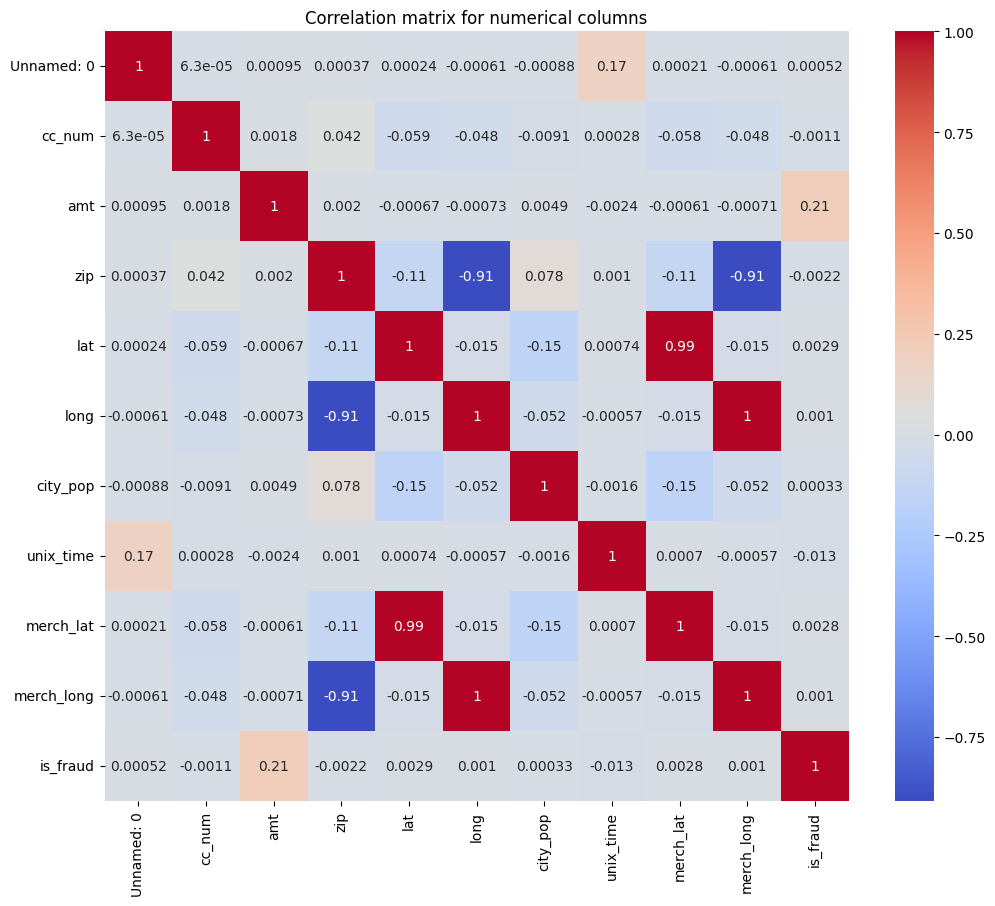

In [ ]:
# Select all numeric columns (both int64 and float64)
df_numerical = df.select_dtypes(include=[np.number])

# Plot correlation matrix for numerical columns
plt.figure(figsize=(12,10))
sns.heatmap(df_numerical.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation matrix for numerical columns")
plt.show()

In [ ]:
for col in df.select_dtypes(include='object'):
    print(f"Number of unique values in column '{col}': {df[col].nunique()}")
    #print(f"Categories in column '{col}': {df[col].unique()} \n")

Number of unique values in column 'trans_date_trans_time': 1819551
Number of unique values in column 'merchant': 693
Number of unique values in column 'category': 14
Number of unique values in column 'first': 355
Number of unique values in column 'last': 486
Number of unique values in column 'gender': 2
Number of unique values in column 'street': 999
Number of unique values in column 'city': 906
Number of unique values in column 'state': 51
Number of unique values in column 'job': 497
Number of unique values in column 'dob': 984
Number of unique values in column 'trans_num': 1852394
Number of unique values in column 'source_file': 2


Class Distribution (%):
is_fraud
0    99.478999
1     0.521001
Name: proportion, dtype: float64


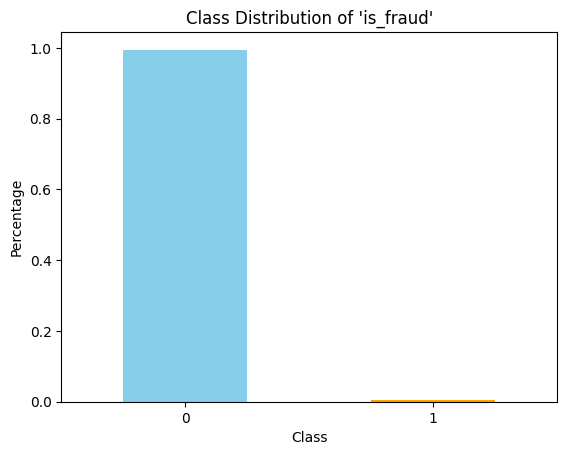

In [ ]:
# Check class distribution
class_distribution = df['is_fraud'].value_counts(normalize=True)

# Display the distribution as percentages
print("Class Distribution (%):")
print(class_distribution * 100)

class_distribution.plot(kind='bar', color=['skyblue', 'orange'])
plt.title("Class Distribution of 'is_fraud'")
plt.xlabel("Class")
plt.ylabel("Percentage")
plt.xticks(rotation=0)
plt.show()

In [ ]:
df_eda = df.copy()
df_eda.head(1)

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,source_file
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,fraudTrain.csv


In [ ]:
# Convert 'trans_date_trans_time' to datetime format
df_eda['trans_date_trans_time'] = pd.to_datetime(df_eda['trans_date_trans_time'])

# Hour of the Transaction
df_eda['transaction_hour'] = df_eda['trans_date_trans_time'].dt.hour

# Day of the Week
df_eda['day_of_week'] = df_eda['trans_date_trans_time'].dt.day_name()  # Keep only weekday names

# Month of the Transaction
df_eda['transaction_month'] = df_eda['trans_date_trans_time'].dt.month

# Part of the Day
def categorize_part_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    elif 21 <= hour or hour < 5:
        return 'Night'

df_eda['part_of_day'] = df_eda['transaction_hour'].apply(categorize_part_of_day)

# Is Weekend
df_eda['is_weekend'] = df_eda['trans_date_trans_time'].dt.weekday.isin([5, 6]).astype(int)

# Display the new features
df_eda[['transaction_hour', 'day_of_week', 'transaction_month', 'part_of_day', 'is_weekend']].head()


,transaction_hour,day_of_week,transaction_month,part_of_day,is_weekend
0,0,Tuesday,1,Night,0
1,0,Tuesday,1,Night,0
2,0,Tuesday,1,Night,0
3,0,Tuesday,1,Night,0
4,0,Tuesday,1,Night,0


In [ ]:
# Convert 'dob' to datetime
df_eda['dob'] = pd.to_datetime(df_eda['dob'], errors='coerce')

# Calculate age as of December 31, 2020
reference_date = datetime(2020, 12, 31)  # Set the reference date to 31st December 2020
df_eda['age'] = (reference_date - df_eda['dob']).dt.days // 365  # Convert days to years

# Display the new 'age' column
df_eda['age'].describe()

,age
count,1.852394e+06
mean,4.675016e+01
std,1.740332e+01
min,1.500000e+01
25%,3.300000e+01
50%,4.500000e+01
75%,5.800000e+01
max,9.600000e+01


In [ ]:
# Create a more detailed age group column
def categorize_age_group(age):
    if age <= 12:
        return 'Child'
    elif 13 <= age <= 17:
        return 'Teenager'
    elif 18 <= age <= 25:
        return 'Young Adult'
    elif 26 <= age <= 40:
        return 'Adult'
    elif 41 <= age <= 60:
        return 'Middle-Aged'
    elif 61 <= age <= 80:
        return 'Senior'
    else:
        return 'Elderly'

df_eda['age_group'] = df_eda['age'].apply(categorize_age_group)

# Display the new 'age_group' column
df_eda[['age', 'age_group']].head()


,age,age_group
0,32,Adult
1,42,Middle-Aged
2,58,Middle-Aged
3,54,Middle-Aged
4,34,Adult


In [ ]:
# Apply the function to calculate distance for each transaction
df_eda = calculate_distance(df_eda, 'lat', 'long', 'merch_lat', 'merch_long', 'distance')

# Display the new 'distance' column
df_eda[['lat', 'long', 'merch_lat', 'merch_long', 'distance']].head()

,lat,long,merch_lat,merch_long,distance
0,36.0788,-81.1781,36.011293,-82.048315,78.597568
1,48.8878,-118.2105,49.159047,-118.186462,30.212176
2,42.1808,-112.2620,43.150704,-112.154481,108.206083
3,46.2306,-112.1138,47.034331,-112.561071,95.673231
4,38.4207,-79.4629,38.674999,-78.632459,77.556744


In [ ]:
df_eda['distance'].describe()

,distance
count,1.852394e+06
mean,7.611173e+01
std,2.911697e+01
min,2.225452e-02
25%,5.532009e+01
50%,7.821638e+01
75%,9.850947e+01
max,1.521172e+02


In [ ]:
# Create bins for 'city_pop'
city_pop_bins = [0, 10000, 50000, 100000, 500000, 1000000, np.inf]
city_pop_labels = ['<10K', '10K-50K', '50K-100K', '100K-500K', '500K-1M', '>1M']

# Bin the 'city_pop' column
df_eda['city_pop_bin'] = pd.cut(df_eda['city_pop'], bins=city_pop_bins, labels=city_pop_labels)

In [ ]:
columns_to_remove = ['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant',
        'first', 'last',  'street', 'city', 'state', 'zip',
       'lat', 'long',  'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long'
]

# Drop the specified columns from df_eda
df_eda.drop(columns=columns_to_remove, inplace=True)

In [ ]:
df_eda.columns

Index(['category', 'amt', 'gender', 'city_pop', 'is_fraud', 'source_file',
       'transaction_hour', 'day_of_week', 'transaction_month', 'part_of_day',
       'is_weekend', 'age', 'age_group', 'distance', 'city_pop_bin'],
      dtype='object')

1) What is the distribution of the target variable is_fraud?

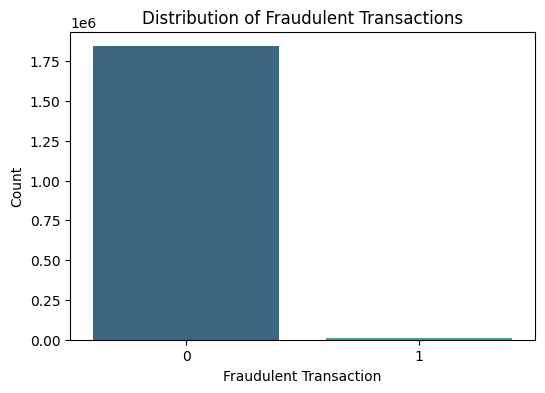

In [ ]:
# Plot the distribution of the target variable
plt.figure(figsize=(6, 4))
sns.countplot(x='is_fraud', data=df_eda, palette='viridis')
plt.title('Distribution of Fraudulent Transactions')
plt.xlabel('Fraudulent Transaction')
plt.ylabel('Count')
plt.show()

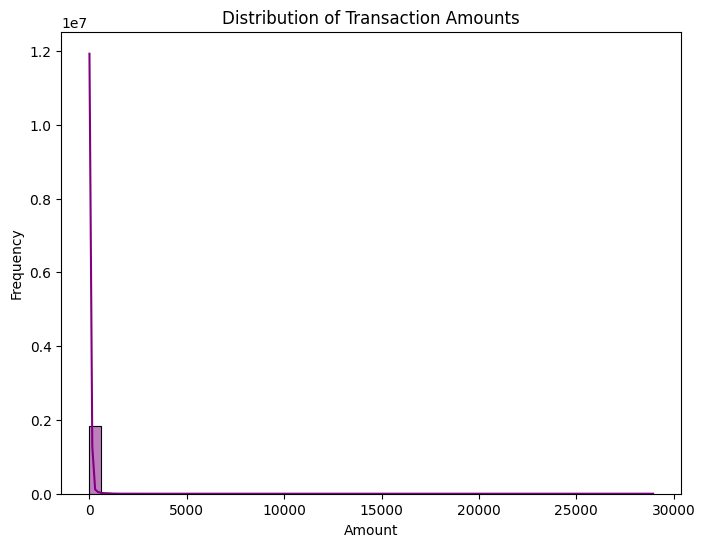

In [ ]:
# Plot the distribution of the transaction amount
plt.figure(figsize=(8, 6))
sns.histplot(df_eda['amt'], kde=True, color='purple', bins=50)
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()

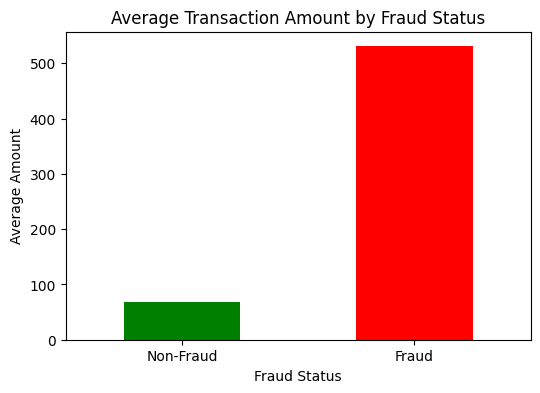

In [ ]:
# Group by 'is_fraud' and calculate the mean transaction amount
avg_amt_fraud = df_eda.groupby('is_fraud')['amt'].mean()

# Plot the result
avg_amt_fraud.plot(kind='bar', color=['green', 'red'], figsize=(6, 4))
plt.title('Average Transaction Amount by Fraud Status')
plt.xlabel('Fraud Status')
plt.ylabel('Average Amount')
plt.xticks(ticks=[0, 1], labels=['Non-Fraud', 'Fraud'], rotation=0)
plt.show()


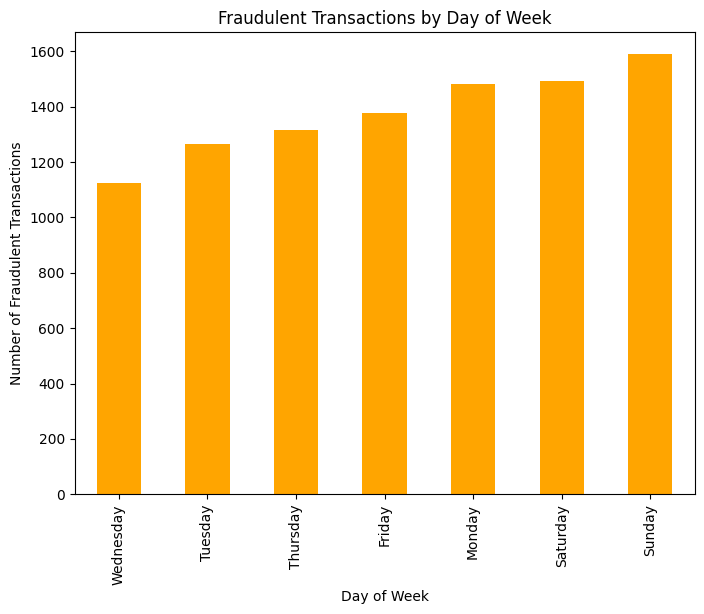

In [ ]:
# Group by 'day_of_week' and calculate the sum of fraudulent transactions
fraud_by_day = df_eda.groupby('day_of_week')['is_fraud'].sum()

# Plot the result
plt.figure(figsize=(8, 6))
fraud_by_day.sort_values().plot(kind='bar', color='orange')
plt.title('Fraudulent Transactions by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Fraudulent Transactions')
plt.show()

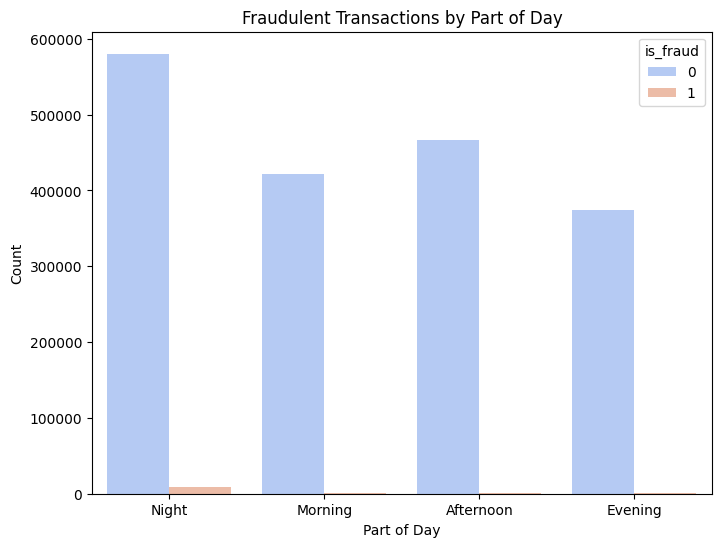

In [ ]:
# Plot the distribution of fraud by part of the day
plt.figure(figsize=(8, 6))
sns.countplot(x='part_of_day', hue='is_fraud', data=df_eda, palette='coolwarm')
plt.title('Fraudulent Transactions by Part of Day')
plt.xlabel('Part of Day')
plt.ylabel('Count')
plt.show()

In [ ]:
# define numerical & categorical columns
numerical_features = [
    feature for feature in df_eda.columns
    if pd.api.types.is_numeric_dtype(df_eda[feature]) and feature != "is_fraud"
]

discrete_numerical_features = [feature for feature in numerical_features if df_eda[feature].nunique() < 25]

continuous_numerical_features = [feature for feature in numerical_features if df_eda[feature].nunique() >= 25]

categorical_features = [feature for feature in df_eda.columns if df_eda[feature].dtype == 'object']

target_column = "is_fraud"

# print column names
print(f'There are {len(numerical_features)} numerical features : {numerical_features}')
print(f'\nThere are {len(discrete_numerical_features)} discrete numerical features : {discrete_numerical_features}')
print(f'\nThere are {len(continuous_numerical_features)} continuos numerical features : {continuous_numerical_features}')
print(f'\nThere are {len(categorical_features)} categorical features : {categorical_features}')

There are 7 numerical features : ['amt', 'city_pop', 'transaction_hour', 'transaction_month', 'is_weekend', 'age', 'distance']

There are 3 discrete numerical features : ['transaction_hour', 'transaction_month', 'is_weekend']

There are 4 continuos numerical features : ['amt', 'city_pop', 'age', 'distance']

There are 6 categorical features : ['category', 'gender', 'source_file', 'day_of_week', 'part_of_day', 'age_group']


In [ ]:
df_eda['age'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1852394 entries, 0 to 1852393
Series name: age
Non-Null Count    Dtype
--------------    -----
1852394 non-null  int64
dtypes: int64(1)
memory usage: 14.1 MB


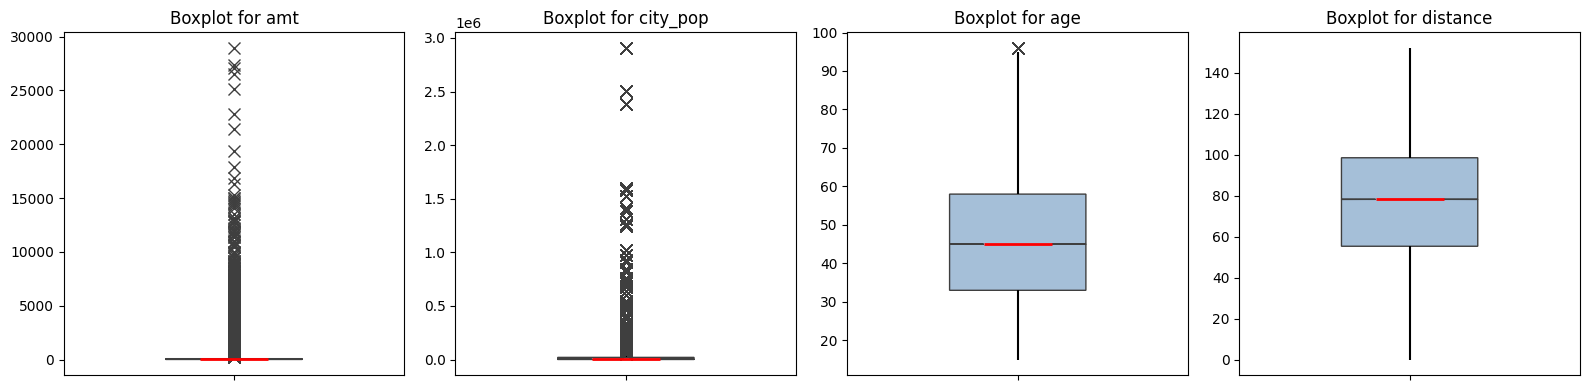

In [ ]:
# Box plot for continuous numerical features

# Calculate the number of rows required to plot all features
num_cols = 4  # 4 plots per row
num_rows = math.ceil(len(continuous_numerical_features) / num_cols)

# Create a figure with subplots (4 plots per row)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, num_rows * num_cols))

# Flatten axes array for easy iteration (in case of multiple rows)
axes = axes.flatten()

# Iterate through numerical features and plot each one
for i, feature in enumerate(continuous_numerical_features):
    sns.boxplot(
        y=df_eda[feature],
        ax=axes[i],
        notch=True,  # Add notch to the boxplot
        showcaps=False,  # Hide the caps
        flierprops={"marker": "x", "color": "r", "markersize": 8},  # Customizing outliers
        boxprops={"facecolor": (.3, .5, .7, .5)},  # Set the box color with transparency
        medianprops={"color": "r", "linewidth": 2},  # Customize the median line
        whiskerprops={"color": "black", "linewidth": 1.5},  # Customize whiskers
        width=0.4  # Shrink the box width
    )
    axes[i].set_title(f'Boxplot for {feature}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

# Hide any unused subplots if there are fewer than 4 features in the last row
for i in range(len(continuous_numerical_features), len(axes)):
    axes[i].axis('off')

# Adjust the layout to make sure all plots are well spaced
plt.tight_layout()
plt.show()

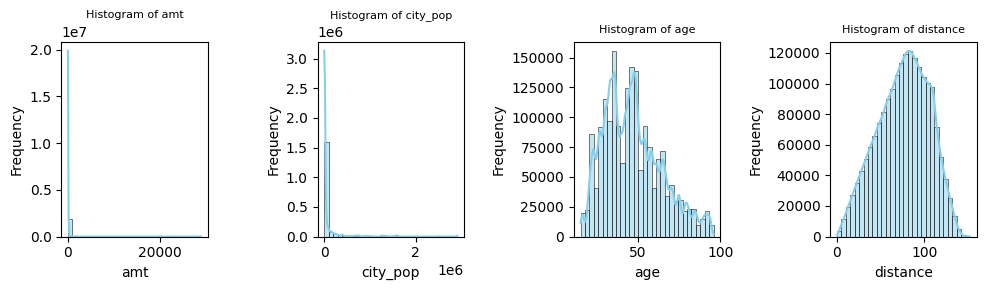

In [ ]:
# Histograms for continuous numerical features
# Calculate the number of rows required to plot all features in a 4x4 grid
num_cols = 4  # 4 plots per row
num_rows = math.ceil(len(continuous_numerical_features) / num_cols)


# Create the subplots dynamically based on the number of numerical features
plt.figure(figsize=(10, 3 * num_rows))  # Adjust figure size based on the number of rows

# Loop through the numerical features to plot individual histograms
for i, feature in enumerate(continuous_numerical_features, 1):
    plt.subplot(num_rows, num_cols, i)  # Create subplots dynamically
    sns.histplot(df_eda[feature], kde=True, bins=30, color='skyblue', edgecolor='black')
    plt.title(f'Histogram of {feature}', fontsize=8)
    plt.xlabel(feature)
    plt.ylabel('Frequency')

# Adjust layout for better visibility
plt.tight_layout()
plt.show()

<div style="color:#8B4513; font-size:24px;">
The 'amt' column is highly skewed, so the Yeo-Johnson transformation will be applied.<br>
The 'city_pop' column is also skewed, but it will be removed. Instead, the categorical column 'city_pop_bin' will be used for the analysis.
</div>

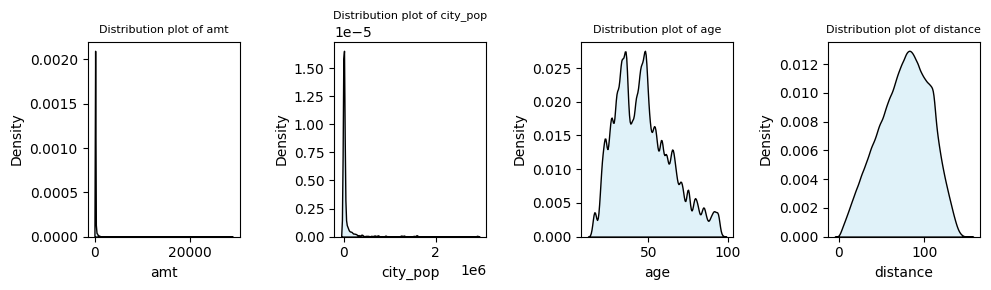

In [ ]:
# Distribution plot continuous numerical features
# Calculate the number of rows required to plot all features in a 4x4 grid
num_cols = 4  # 4 plots per row
num_rows = math.ceil(len(continuous_numerical_features) / num_cols)


# Create the subplots dynamically based on the number of numerical features
plt.figure(figsize=(10, 3 * num_rows))  # Adjust figure size based on the number of rows

# Loop through the numerical features to plot distribution plots
for i, feature in enumerate(continuous_numerical_features, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.kdeplot(df_eda[feature], fill=True, color='skyblue', edgecolor='black')
    plt.title(f'Distribution plot of {feature}', fontsize=8)
    plt.xlabel(feature)
    plt.ylabel('Density')

# Adjust layout for better visibility
plt.tight_layout()
plt.show()

In [ ]:
# Check for Skewness in Numerical Columns
for feature in continuous_numerical_features:
    skewness = df_eda[feature].skew()
    if abs(skewness) > 1:
        print(f"'{feature}' is highly skewed with skewness: {skewness:.2f}")

'amt' is highly skewed with skewness: 40.81
'city_pop' is highly skewed with skewness: 5.59


In [ ]:
# Check for Multicollinearity
# Compute VIF for each numerical feature
X = df_eda[continuous_numerical_features]
X = add_constant(X)  # Add a constant column for VIF calculation
vif = pd.DataFrame()
vif['Feature'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

    Feature        VIF
0     const  15.587590
1       amt   1.000130
2  city_pop   1.008367
3       age   1.008353
4  distance   1.000131


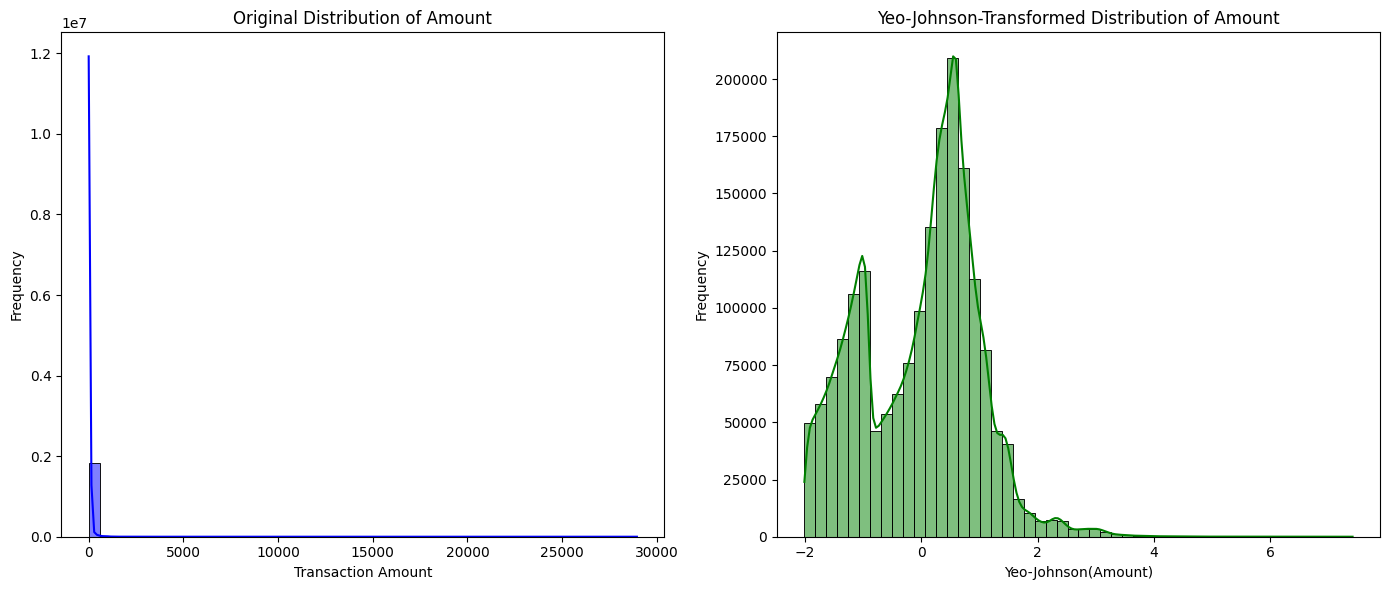

In [ ]:
# Apply Yeo-Johnson Transformation transformation

transformation = PowerTransformer(method='yeo-johnson')
df_eda['amt_yeo_johnson'] = transformation.fit_transform(df_eda[['amt']])

# Plot original and transformed distributions side by side
plt.figure(figsize=(14, 6))

# Original Distribution
plt.subplot(1, 2, 1)
sns.histplot(df_eda['amt'], bins=50, kde=True, color='blue')
plt.title('Original Distribution of Amount')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')

# Transformed Distribution
plt.subplot(1, 2, 2)
sns.histplot(df_eda['amt_yeo_johnson'], bins=50, kde=True, color='green')
plt.title('Yeo-Johnson-Transformed Distribution of Amount')
plt.xlabel('Yeo-Johnson(Amount)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

<div style="background-color:#EDE7F6; padding: 10px; border-radius: 10px;">
  <span style="color:#28A745; font-weight:bold;">5) Data Preprocessing</span>
</div>

In [ ]:
# Filter the dataframe to create the training data by selecting rows where the 'source_file' is in the 'train_files' list
# Drop the 'source_file' column as it is not needed for training the model
train_df = df[df['source_file'].isin(train_files)].drop(columns=['source_file'])

# Filter the dataframe to create the test data by selecting rows where the 'source_file' is in the 'test_files' list
# Drop the 'source_file' column as it is not needed for testing the model
test_df = df[df['source_file'].isin(test_files)].drop(columns=['source_file'])

# Print the shapes of the training and testing data to confirm the separation of data into train and test sets
print(f"Train data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")

Train data shape: (1296675, 23)
Test data shape: (555719, 23)


In [ ]:
test_df.head(2)

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
1296675,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,SC,29209,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1296676,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,UT,84002,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0


In [ ]:
# Select feature columns (independent variables) from the training data to create the training set (X_train)
X_train_raw = train_df.drop(columns=target_column, axis=1)

# Select target columns (dependent variables) from the training data to create the target set (y_train)
y_train = train_df[target_column]

# Select feature columns (independent variables) from the test data to create the test set (X_test)
X_test_raw = test_df.drop(columns=target_column, axis=1)

# Select target columns (dependent variables) from the test data to create the target set (y_test)
y_test = test_df[target_column]

# Print the shapes of the training and testing datasets to verify the number of rows and columns for each
print(f"Shape of X_train_raw: {X_train_raw.shape}")
print(f"Shape of X_test_raw: {X_test_raw.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train_raw: (1296675, 22)
Shape of X_test_raw: (555719, 22)
Shape of y_train: (1296675,)
Shape of y_test: (555719,)


In [ ]:
class ChangeDataType(BaseEstimator, TransformerMixin):
    # Converts specified columns to datetime format.
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for col in self.columns:
            X[col] = pd.to_datetime(X[col], errors='coerce')
        return X

class DateTimeFeatures(BaseEstimator, TransformerMixin):
    # Extracts date and time-related features like hour, month, day of the week, and part of the day.
    def __init__(self, date_column, transaction_hour_bins, transaction_hour_labels):
        self.date_column = date_column
        self.transaction_hour_bins = transaction_hour_bins
        self.transaction_hour_labels = transaction_hour_labels
        self.new_columns = ['transaction_hour', 'transaction_month', 'is_weekend', 'day_of_week', 'part_of_day']

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X['transaction_hour'] = X[self.date_column].dt.hour
        X['transaction_month'] = X[self.date_column].dt.month
        X['is_weekend'] = X[self.date_column].dt.weekday.isin([5, 6]).astype(int)

        # Day of week: Monday=0, Sunday=6
        X['day_of_week'] = X[self.date_column].dt.day_name()

        # Part of day classification
        X['part_of_day'] = pd.cut(X['transaction_hour'],
                                  bins=self.transaction_hour_bins,
                                  labels=self.transaction_hour_labels,
                                  right=True)
        return X


class AgeFeature(BaseEstimator, TransformerMixin):
    # Calculates age based on the date of birth (DOB) column.
    def __init__(self, dob_column):
        self.dob_column = dob_column
        self.new_column = 'age'

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        reference_date = pd.Timestamp(2020, 12, 31)
        X[self.new_column] = (reference_date - X[self.dob_column]).dt.days // 365
        return X

class CalculateDistance(BaseEstimator, TransformerMixin):
    # Calculates the distance between two geographical points using the Haversine formula.
    def __init__(self, lat_col, long_col, merch_lat_col, merch_long_col):
        self.lat_col = lat_col
        self.long_col = long_col
        self.merch_lat_col = merch_lat_col
        self.merch_long_col = merch_long_col
        self.new_column = 'distance'

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        # Convert latitudes and longitudes to radians
        lat1 = np.radians(X[self.lat_col])
        lon1 = np.radians(X[self.long_col])
        lat2 = np.radians(X[self.merch_lat_col])
        lon2 = np.radians(X[self.merch_long_col])

        # Haversine formula to calculate distance
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
        R = 6371  # Radius of the Earth in kilometers
        X[self.new_column] = R * c  # Distance in kilometers

        return X

class BinCityPopulation(BaseEstimator, TransformerMixin):
    # Groups city population into bins with specified labels.
    def __init__(self, city_pop_bins, city_pop_labels):
        self.city_pop_bins = city_pop_bins
        self.city_pop_labels = city_pop_labels
        self.new_column = 'city_pop_bin'

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X[self.new_column] = pd.cut(X['city_pop'], bins=self.city_pop_bins, labels=self.city_pop_labels)
        return X

class YeoJohnsonTransformer(BaseEstimator, TransformerMixin):
    # Applies the Yeo-Johnson transformation to normalize the 'amt' column.
    def __init__(self):
        self.transformer = PowerTransformer(method='yeo-johnson')
        self.new_column = 'amt_yeo_johnson'

    def fit(self, X, y=None):
        self.transformer.fit(X[['amt']])
        return self

    def transform(self, X):
        X = X.copy()
        X[self.new_column] = self.transformer.transform(X[['amt']])
        return X


class DropColumns(BaseEstimator, TransformerMixin):
    # Drops specified columns from the dataset.
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.drop(columns=self.columns, errors='ignore')
        self.remaining_columns = X.columns
        return X


class LabelEncoding(BaseEstimator, TransformerMixin):
    # Performs label encoding for specified categorical columns.
    def __init__(self, columns):
        self.columns = columns
        self.label_encoders = {}

    def fit(self, X, y=None):
        for col in self.columns:
            le = LabelEncoder()
            le.fit(X[col])
            self.label_encoders[col] = le
        return self

    def transform(self, X):
        X = X.copy()
        for col in self.columns:
            X[col] = self.label_encoders[col].transform(X[col])
        return X

class ScaleFeatures(BaseEstimator, TransformerMixin):
    # Scales numerical features to a range of 0 to 1 using MinMaxScaler.
    def __init__(self):
        self.scaler = MinMaxScaler()

    def fit(self, X, y=None):
        self.scaler.fit(X)
        return self

    def transform(self, X):
        X = X.copy()
        X[:] = self.scaler.transform(X)
        return X

In [ ]:
# Preprocessing pipeline
city_pop_bins = [0, 10000, 50000, 100000, 500000, 1000000, np.inf]
city_pop_labels = ['<10K', '10K-50K', '50K-100K', '100K-500K', '500K-1M', '>1M']

transaction_hour_bins=[-1, 5, 11, 17, 21, 24]
transaction_hour_labels=['Late Night', 'Morning', 'Afternoon', 'Evening', 'Night']

drop_columns = ['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'amt',
                'first', 'last', 'street', 'city', 'state', 'zip', 'lat', 'long',
                'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat', 'merch_long']

categorical_features = ['category', 'gender', 'day_of_week', 'part_of_day', 'city_pop_bin']

preprocessor = Pipeline([
    ('change_dtype', ChangeDataType(columns=['trans_date_trans_time', 'dob'])),
    ('datetime_features', DateTimeFeatures(date_column='trans_date_trans_time',
                                           transaction_hour_bins = transaction_hour_bins,
                                           transaction_hour_labels = transaction_hour_labels)),
    ('age_feature', AgeFeature(dob_column='dob')),
    ('calculate_distance', CalculateDistance(lat_col='lat', long_col='long',
                                             merch_lat_col='merch_lat', merch_long_col='merch_long')),
    ('bin_city_pop', BinCityPopulation(city_pop_bins = city_pop_bins, city_pop_labels = city_pop_labels)),
    ('yeo_johnson', YeoJohnsonTransformer()),
    ('drop_columns', DropColumns(columns=drop_columns)),
    ('label_encoding', LabelEncoding(columns=categorical_features)),
    ('scale_features', ScaleFeatures()),
])

In [ ]:
# Fit and transform the training data
train_preprocessed = preprocessor.fit_transform(X_train_raw)
train_preprocessed[target_column] = y_train.values
train_preprocessed.head(2)

,category,gender,transaction_hour,transaction_month,is_weekend,day_of_week,part_of_day,age,distance,city_pop_bin,amt_yeo_johnson,is_fraud
0,0.615385,0,0.0,0.0,0,0.833333,0.5,0.209877,0.516620,0.8,0.073333,0
1,0.307692,0,0.0,0.0,0,0.833333,0.5,0.333333,0.198494,0.8,0.309368,0


In [ ]:
# Transform the test data
test_preprocessed = preprocessor.transform(X_test_raw)
test_preprocessed[target_column] = y_test.values
test_preprocessed.sample(2)

,category,gender,transaction_hour,transaction_month,is_weekend,day_of_week,part_of_day,age,distance,city_pop_bin,amt_yeo_johnson,is_fraud
1835321,0.615385,0,0.391304,1.000000,0,0.166667,0.75,0.555556,0.646212,0.8,0.118747,0
1583310,0.153846,0,0.391304,0.818182,0,0.833333,0.75,0.012346,0.749983,0.8,0.281770,0


In [ ]:
# Save the preprocessor pipeline to a file for later use
joblib.dump(preprocessor, 'preprocessor.joblib')

['preprocessor.joblib']

In [ ]:
# Load the preprocessor pipeline from the saved file
preprocessor_loaded = joblib.load('preprocessor.joblib')

In [ ]:
# Class to oversample the minority class using the Synthetic Minority Over-sampling Technique (SMOTE)
class SMOTESampler:
    def __init__(self, target_column):
        self.target_column = target_column
        self.sampler = SMOTE(random_state=random_state)

    # Fits the sampler and resamples the data to balance the target column
    def fit_resample(self, df):
        X = df.drop(columns=[self.target_column])
        y = df[self.target_column]
        X_resampled, y_resampled = self.sampler.fit_resample(X, y)
        return X_resampled.assign(**{self.target_column: y_resampled})


# Class to oversample the minority class using the Adaptive Synthetic (ADASYN) method
class ADASYN_Sampler:
    def __init__(self, target_column):
        self.target_column = target_column
        self.sampler = ADASYN(random_state=random_state)

    # Fits the sampler and resamples the data to balance the target column
    def fit_resample(self, df):
        X = df.drop(columns=[self.target_column])
        y = df[self.target_column]
        X_resampled, y_resampled = self.sampler.fit_resample(X, y)
        return X_resampled.assign(**{self.target_column: y_resampled})


# Class to reduce data imbalance by removing Tomek Links (overlapping majority samples near minority samples)
class TomekLinksSampler:
    def __init__(self, target_column):
        self.target_column = target_column
        self.sampler = TomekLinks()

    # Fits the sampler and resamples the data to reduce Tomek Links
    def fit_resample(self, df):
        X = df.drop(columns=[self.target_column])
        y = df[self.target_column]
        X_resampled, y_resampled = self.sampler.fit_resample(X, y)
        return X_resampled.assign(**{self.target_column: y_resampled})


# Class to combine SMOTE oversampling and Tomek Links removal for handling imbalanced data
class SMOTETomekSampler:
    def __init__(self, target_column):
        self.target_column = target_column
        self.sampler = SMOTETomek(random_state=random_state)

    # Fits the sampler and resamples the data using a combination of SMOTE and Tomek Links
    def fit_resample(self, df):
        X = df.drop(columns=[self.target_column])
        y = df[self.target_column]
        X_resampled, y_resampled = self.sampler.fit_resample(X, y)
        return X_resampled.assign(**{self.target_column: y_resampled})

In [ ]:
# Apply SMOTE
smote_sampler = SMOTESampler(target_column=target_column)
smote_resampled_df = smote_sampler.fit_resample(train_preprocessed)
print(f"SMOTE completed")

# Apply ADASYN
adasyn_sampler = ADASYN_Sampler(target_column=target_column)
adasyn_resampled_df = adasyn_sampler.fit_resample(train_preprocessed)
print(f"ADASYN completed")

# Apply TomekLinks
#tomek_sampler = TomekLinksSampler(target_column=target_column)
#tomek_resampled_df = tomek_sampler.fit_resample(train_preprocessed)
#print(f"TomekLinks completed")

# Apply SMOTETomek
#smotetomek_sampler = SMOTETomekSampler(target_column=target_column)
#smotetomek_resampled_df = smotetomek_sampler.fit_resample(train_preprocessed)
#print(f"SMOTomek completed")

# Inspect the resampled datasets
print(smote_resampled_df[target_column].value_counts())
print(adasyn_resampled_df[target_column].value_counts())
#print(tomek_resampled_df[target_column].value_counts())
#print(smotetomek_resampled_df[target_column].value_counts())

SMOTE completed
ADASYN completed
is_fraud
0    1289169
1    1289169
Name: count, dtype: int64
is_fraud
1    1289977
0    1289169
Name: count, dtype: int64


<div style="background-color:#EDE7F6; padding: 10px; border-radius: 10px;">
  <span style="color:#28A745; font-weight:bold;">7) Model Training and Evaluation</span>
</div>

In [ ]:
# Defining the models for classification
base_models_classification = {
    "logistic_regression": LogisticRegression(random_state=random_state),
#    "svm": SVC(random_state=random_state, probability=True),  # SVM with probability estimates enabled
    "decision_tree": DecisionTreeClassifier(random_state=random_state),
#    "random_forest": RandomForestClassifier(random_state=random_state),
#    "gradient_boosting": GradientBoostingClassifier(random_state=random_state),
#    "adaboost": AdaBoostClassifier(random_state=random_state),
#    "xgboost": XGBClassifier(random_state=random_state, use_label_encoder=False, eval_metric="logloss"),
#    "catboost": CatBoostClassifier(random_state=random_state, verbose=0),
}

In [ ]:
datasets = {
    "SMOTE": smote_resampled_df,
    "ADASYN": adasyn_resampled_df,
#    "SMOTETOMEK": smotetomek_resampled_df,
}

In [ ]:
def cross_validate_models(train_data, target_column='is_fraud', base_models=base_models_classification, metric="f1", cv=None):
    """
    Perform cross-validation for each model and return a DataFrame with the scores.

    Parameters:
    - train_data: DataFrame containing the features and the target column.
    - target_column: The column name that contains the target variable.
    - base_models: Dictionary containing the models to evaluate.
    - metric: Scoring metric for evaluation, default is "f1".
    - cv: Cross-validation strategy, default is StratifiedKFold.

    Returns:
    - DataFrame with model names and their respective cross-validation scores.
    """
    # Extract features and target
    X_train = train_data.drop(columns=[target_column])  # Features
    y_train = train_data[target_column]  # Target

    # If no cv is provided, use StratifiedKFold as the default
    if cv is None:
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

    # Store results
    results = []

    # Define the available metrics
    scoring_metrics = {
        "f1": make_scorer(f1_score),
        "roc_auc": make_scorer(roc_auc_score)
    }

    # Check if the provided metric is valid
    if metric not in scoring_metrics:
        raise ValueError(f"Invalid metric: {metric}. Available metrics: {', '.join(scoring_metrics.keys())}")

    # Get the scorer for the chosen metric
    scorer = scoring_metrics[metric]

    # Iterate over models
    for model_name, model in base_models.items():
        # Perform cross-validation and collect the selected metric scores
        scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=scorer)
        for score in scores:
            results.append({"Model": model_name, f"{metric.capitalize()} Score": score})

    # Return results as a DataFrame
    return pd.DataFrame(results)

In [ ]:
# Function to plot box plot
def plot_f1_boxplot(df):
    """
    Plot a box plot for F1 scores of each model.

    Parameters:
    - df: DataFrame containing model names and their respective F1 scores.
    """
    plt.figure(figsize=(10, 6))
    sns.boxplot(x="Model", y="F1 Score", data=df)
    plt.title("F1 Score Box plot")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

F1 score for SMOTE resampled data


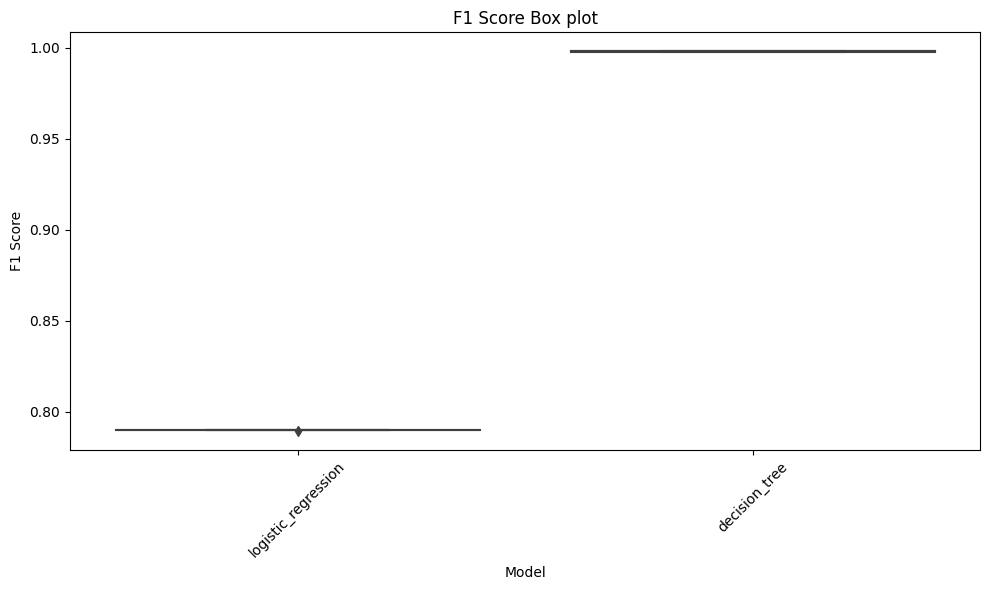

F1 score for ADASYN resampled data


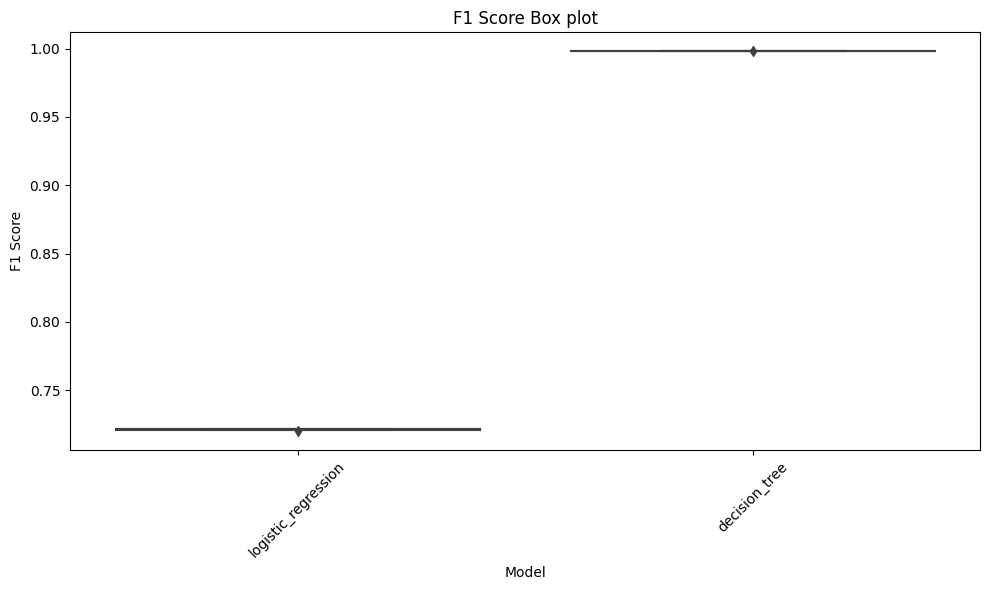

In [ ]:
# Initialize the results dictionary
all_cv_results = {}

# Evaluate each dataset
for dataset_name, dataset in datasets.items():
    # Get cross-validation results for the current dataset
    results = cross_validate_models(dataset, target_column='is_fraud', base_models=base_models_classification, metric="f1")

    # Store the results in the dictionary
    all_cv_results[dataset_name] = results

    # Plot box plot for this dataset
    print(f"F1 score for {dataset_name} resampled data")
    plot_f1_boxplot(results)


In [ ]:
all_cv_results

{'SMOTE':                  Model  F1 Score
 0  logistic_regression  0.789755
 1  logistic_regression  0.789789
 2  logistic_regression  0.789966
 3  logistic_regression  0.789885
 4  logistic_regression  0.789410
 5        decision_tree  0.997833
 6        decision_tree  0.997996
 7        decision_tree  0.997866
 8        decision_tree  0.998040
 9        decision_tree  0.997945,
 'ADASYN':                  Model  F1 Score
 0  logistic_regression  0.720215
 1  logistic_regression  0.721876
 2  logistic_regression  0.721025
 3  logistic_regression  0.721382
 4  logistic_regression  0.721302
 5        decision_tree  0.997906
 6        decision_tree  0.997925
 7        decision_tree  0.997923
 8        decision_tree  0.997989
 9        decision_tree  0.997899}

In [ ]:
def evaluate_classification_models(X_train, y_train, X_test, y_test, base_models):
    """
    Train base classifiers (default settings) and evaluate performance.

    Args:
        X_train: Training features
        y_train: Training target
        X_test: Testing features
        y_test: Testing target
        base_models: Dictionary of base classifiers with their model names and objects

    Returns:
        report: Dictionary containing accuracy, precision, recall, F1 score,
                confusion matrix, and classification report for each model
    """
    # Initialize an empty dictionary to store results
    report = {}

    # Loop through each base model
    for model_name, model in base_models.items():

        # Train the model on training data
        model.fit(X_train, y_train)

        # Make predictions on training and testing data
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Calculate metrics
        train_accuracy = accuracy_score(y_train, y_train_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)

        train_precision_pos_class = precision_score(y_train, y_train_pred, pos_label=1, zero_division=0)
        test_precision_pos_class = precision_score(y_test, y_test_pred, pos_label=1, zero_division=0)

        train_recall_pos_class = recall_score(y_train, y_train_pred, pos_label=1, zero_division=0)
        test_recall_pos_class = recall_score(y_test, y_test_pred, pos_label=1, zero_division=0)

        train_f1_pos_class = f1_score(y_train, y_train_pred, pos_label=1, zero_division=0)
        test_f1_pos_class = f1_score(y_test, y_test_pred, pos_label=1, zero_division=0)

        # Generate classification reports and confusion matrices for test data
        test_classification_report = classification_report(y_test, y_test_pred, zero_division=0)
        test_confusion_matrix = confusion_matrix(y_test, y_test_pred)

        # Store evaluation metrics
        report[model_name] = {
            'train_accuracy': train_accuracy,
            'test_accuracy': test_accuracy,
            'train_precision_pos_class': train_precision_pos_class,
            'test_precision_pos_class': test_precision_pos_class,
            'train_recall_pos_class': train_recall_pos_class,
            'test_recall_pos_class': test_recall_pos_class,
            'train_f1_pos_class': train_f1_pos_class,
            'test_f1_pos_class': test_f1_pos_class,
            'test_classification_report': test_classification_report,
            'test_confusion_matrix': test_confusion_matrix.tolist()  # Convert to list for better readability
        }

    return report

In [ ]:
# Initialize the results dictionary
all_base_model_results = {}

X_test = test_preprocessed.drop(columns=[target_column], axis= 'columns')
y_test = test_preprocessed[target_column]

# Evaluate each dataset
for dataset_name, dataset in datasets.items():
    # Get cross-validation results for the current dataset
    X_train = dataset.drop(columns=[target_column], axis= 'columns')
    y_train = dataset[target_column]

    base_model_result = evaluate_classification_models(X_train, y_train, X_test, y_test, base_models_classification)
    print(f"{dataset_name} completed")
    # Store the results in the dictionary
    all_base_model_results[dataset_name] = base_model_result

SMOTE completed
ADASYN completed


In [ ]:
def print_results_nicely(results_dict):
    """
    Print the results from all_base_model_results in a structured format.

    Args:
        results_dict: Dictionary with dataset names as keys and evaluation results as values.
    """
    for dataset_name, model_results in results_dict.items():
        print(f"\nResults for Dataset: {dataset_name}")
        print("-" * 50)

        # Convert model results to a DataFrame for better formatting
        results_df = pd.DataFrame(model_results).T.reset_index()
        results_df.rename(columns={'index': 'Model'}, inplace=True)

        # Display the DataFrame
        print(results_df.to_string(index=False))  # Print without row indices
        print("-" * 50)

# Example usage
print_results_nicely(all_base_model_results)


Results for Dataset: SMOTE
--------------------------------------------------
              Model train_accuracy test_accuracy train_precision_pos_class test_precision_pos_class train_recall_pos_class test_recall_pos_class train_f1_pos_class test_f1_pos_class                                                                                                                                                                                                                                                                                                                     test_classification_report          test_confusion_matrix
logistic_regression       0.790911      0.846503                  0.794155                 0.019029               0.785396                0.7669           0.789751          0.037137               precision    recall  f1-score   support\n\n           0       1.00      0.85      0.92    553574\n           1       0.02      0.77      0.04      2145\n\n    accuracy          

In [ ]:
# Save the serializable report to a JSON file
with open('base_model_results_report.json', 'w') as json_file:
    json.dump(all_base_model_results, json_file, indent=4)

print("Base models report saved to 'base_model_results_report.json'")

all_base_model_results

Base models report saved to 'base_model_results_report.json'


{'SMOTE': {'logistic_regression': {'train_accuracy': 0.7909106563995877,
   'test_accuracy': 0.846503358711867,
   'train_precision_pos_class': 0.794155064904506,
   'test_precision_pos_class': 0.01902922055387178,
   'train_recall_pos_class': 0.7853958635368986,
   'test_recall_pos_class': 0.7668997668997669,
   'train_f1_pos_class': 0.7897511776949511,
   'test_f1_pos_class': 0.03713695522118499,
   'test_classification_report': '              precision    recall  f1-score   support\n\n           0       1.00      0.85      0.92    553574\n           1       0.02      0.77      0.04      2145\n\n    accuracy                           0.85    555719\n   macro avg       0.51      0.81      0.48    555719\nweighted avg       1.00      0.85      0.91    555719\n',
   'test_confusion_matrix': [[468773, 84801], [500, 1645]]},
  'decision_tree': {'train_accuracy': 1.0,
   'test_accuracy': 0.9971424406939479,
   'train_precision_pos_class': 1.0,
   'test_precision_pos_class': 0.5960676095205


Plotting Confusion Matrices for Dataset: SMOTE


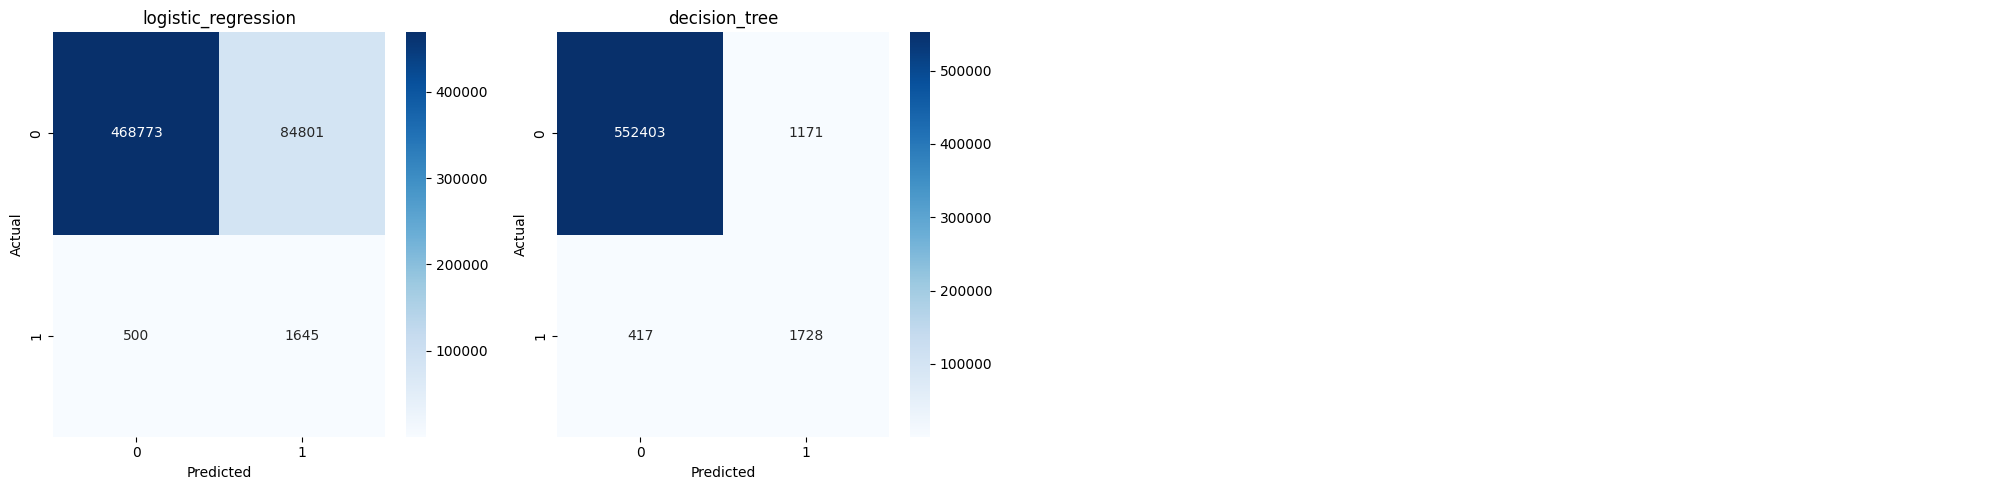


Plotting Confusion Matrices for Dataset: ADASYN


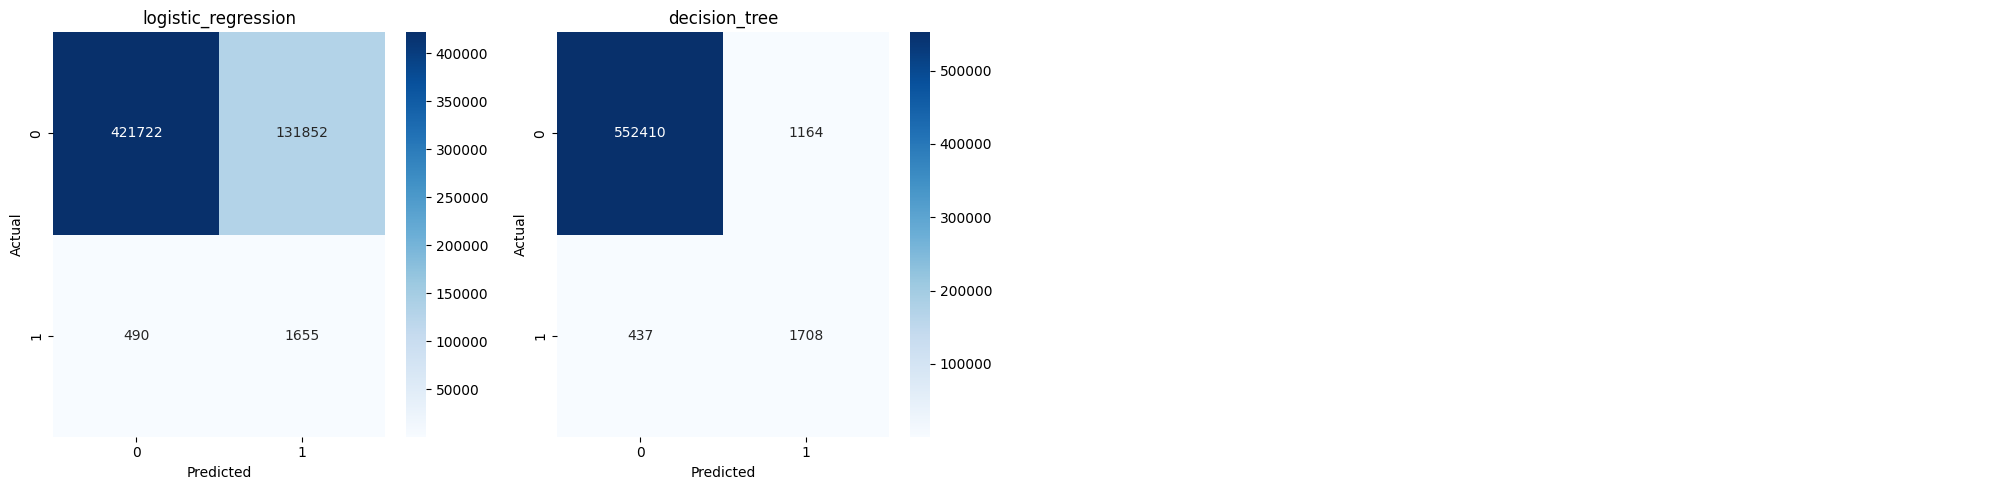

In [ ]:
def plot_confusion_matrices(results_dict, n_cols=4):
    """
    Plot confusion matrices from all_base_model_results.

    Args:
        results_dict: Dictionary with dataset names as keys and evaluation results as values.
        n_cols: Number of plots per row (default is 4).
    """
    # Loop through datasets and models to collect confusion matrices
    for dataset_name, model_results in results_dict.items():
        print(f"\nPlotting Confusion Matrices for Dataset: {dataset_name}")

        # Number of models in the dataset
        n_models = len(model_results)
        n_rows = (n_models + n_cols - 1) // n_cols  # Calculate rows dynamically

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
        axes = axes.flatten()

        for idx, (model_name, metrics) in enumerate(model_results.items()):
            if idx >= len(axes):  # Safety check
                break

            # Get confusion matrix
            cm = metrics['test_confusion_matrix']

            # Plot confusion matrix
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[idx])
            axes[idx].set_title(f"{model_name}")
            axes[idx].set_xlabel("Predicted")
            axes[idx].set_ylabel("Actual")

        # Turn off any unused axes
        for idx in range(len(model_results), len(axes)):
            axes[idx].axis('off')

        plt.tight_layout()
        plt.show()

# Example usage
plot_confusion_matrices(all_base_model_results)

In [ ]:
def find_best_model_and_dataset(
    results,
    test_metric='test_f1_pos_class',
    train_metric='train_f1_pos_class',
    tolerance=0.1
):
    """
    Find the best model and dataset based on test metric and overfitting gap.
    Includes comprehensive logging for all models and sampling methods.

    Args:
        results: Nested dictionary with sampling methods, models, and evaluation metrics.
        test_metric: Metric to evaluate model performance on the test set.
        train_metric: Metric to evaluate model performance on the training set.
        tolerance: Percentage (as decimal) within which models are considered close to the best.

    Returns:
        best_sampling_method: Name of the sampling method with the best-performing model (or None).
        best_model: Name of the best-performing model (or None).
        best_metrics: Metrics of the best-performing model (or None).
    """
    # Step 1: Find the highest test_f1_score across all models
    max_test_score = -float('inf')
    for sampling_method, models in results.items():
        for model_name, metrics in models.items():
            max_test_score = max(max_test_score, metrics[test_metric])

    # Initialize variables for the best model selection
    best_sampling_method = None
    best_base_model = None
    smallest_gap = float('inf')

    # Step 2: Iterate through all models to log details and identify the best model
    for sampling_method, models in results.items():
        for model_name, metrics in models.items():
            train_score = metrics[train_metric]
            test_score = metrics[test_metric]
            overfitting_gap = train_score - test_score

            # Debugging: Log details for every model
            print(f"Dataset: {sampling_method}, Model: {model_name}, "
                  f"Train Score: {train_score:.4f}, Test Score: {test_score:.4f}, "
                  f"Overfitting Gap: {overfitting_gap:.4f}")

            # Check if the model falls within the tolerance range
            if test_score >= max_test_score * (1 - tolerance):
                # Select the model with the smallest overfitting gap
                if overfitting_gap < smallest_gap:
                    smallest_gap = overfitting_gap
                    best_sampling_method = sampling_method
                    best_base_model = model_name

    return best_sampling_method, best_base_model


# Example usage
best_sampling_method, best_base_model = find_best_model_and_dataset(
    results = all_base_model_results,
    test_metric='test_f1_pos_class',
    train_metric='train_f1_pos_class',
)

print(f"Best Sampling method: {best_sampling_method}")
print(f"Best Model: {best_base_model}")

Dataset: SMOTE, Model: logistic_regression, Train Score: 0.7898, Test Score: 0.0371, Overfitting Gap: 0.7526
Dataset: SMOTE, Model: decision_tree, Train Score: 1.0000, Test Score: 0.6852, Overfitting Gap: 0.3148
Dataset: ADASYN, Model: logistic_regression, Train Score: 0.7212, Test Score: 0.0244, Overfitting Gap: 0.6968
Dataset: ADASYN, Model: decision_tree, Train Score: 1.0000, Test Score: 0.6809, Overfitting Gap: 0.3191
Best Sampling method: SMOTE
Best Model: decision_tree


In [ ]:
# Parameter grids for different models
params_grid = {
    "logistic_regression": {
        "penalty": ["l1", "l2", "elasticnet", None],
        "C": [0.01, 0.1, 1, 10, 100],
        "solver": ["lbfgs", "saga", "liblinear"],
        "max_iter": [100, 200, 500],
    },
    "svm": {
        "C": [0.1, 1, 10, 100],
        "kernel": ["linear", "rbf", "poly", "sigmoid"],
        "gamma": ["scale", "auto"],
        "degree": [2, 3, 4],  # For polynomial kernel
    },

    "decision_tree": {
        "criterion": ["gini", "entropy"],
        "max_depth": [20, 30],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 2],
        "max_features": ["sqrt"]
    },

    "random_forest": {
        "n_estimators": [50, 100, 200],
        "criterion": ["gini", "entropy"],
        "max_depth": [None, 10, 20, 30, 50],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "max_features": [None, "sqrt", "log2"],
        "bootstrap": [True, False],
    },
    "gradient_boosting": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 0.2],
        "max_depth": [3, 5, 10],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "subsample": [0.8, 1.0],
        "max_features": [None, "sqrt", "log2"],
    },
    "adaboost": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 1],
        "algorithm": ["SAMME", "SAMME.R"],
        "base_estimator": [
            DecisionTreeClassifier(max_depth=1),
            DecisionTreeClassifier(max_depth=3),
        ],  # Using weak learners
    },
    "xgboost": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 0.2],
        "max_depth": [3, 5, 10],
        "min_child_weight": [1, 3, 5],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.8, 1.0],
        "gamma": [0, 0.1, 0.2],
    },
    "catboost": {
        "iterations": [100, 200, 500],
        "learning_rate": [0.01, 0.1, 0.2],
        "depth": [4, 6, 8],
        "l2_leaf_reg": [1, 3, 5, 7],
        "border_count": [32, 64, 128],
        "bootstrap_type": ["Bayesian", "Bernoulli", "MVS"],
    },
}

In [ ]:
def hyperparameter_tuning(X_train, y_train, X_test, y_test, models, params):
    """
    Perform hyperparameter tuning, train models, and evaluate performance for classification problems.

    Args:
        X_train: Training features
        y_train: Training target
        X_test: Testing features
        y_test: Testing target
        models: Dictionary of model name and model objects
        params: Dictionary of model name and hyperparameter grid

    Returns:
        report: Dictionary containing classification metrics and best hyperparameters
    """
    report = {}  # Store results

    for model_name, model in models.items():
        try:
            # Extract hyperparameter grid
            param_grid = params[model_name]

            # Hyperparameter tuning with GridSearchCV
            grid_search = GridSearchCV(
                estimator=model,
                param_grid=param_grid,
                cv=3,
                n_jobs=-1,
                scoring='f1',  # Use F1 score for classification optimization
            )
            grid_search.fit(X_train, y_train)

            # Best model from GridSearch
            best_model = grid_search.best_estimator_

            # Predictions using the best model
            y_train_pred = best_model.predict(X_train)
            y_test_pred = best_model.predict(X_test)

            # Calculate classification metrics
            train_accuracy = accuracy_score(y_train, y_train_pred)
            test_accuracy = accuracy_score(y_test, y_test_pred)

            train_precision_pos_class = precision_score(y_train, y_train_pred, pos_label=1, zero_division=0)
            test_precision_pos_class = precision_score(y_test, y_test_pred, pos_label=1, zero_division=0)

            train_recall_pos_class = recall_score(y_train, y_train_pred, pos_label=1, zero_division=0)
            test_recall_pos_class = recall_score(y_test, y_test_pred, pos_label=1, zero_division=0)

            train_f1_pos_class = f1_score(y_train, y_train_pred, pos_label=1, zero_division=0)
            test_f1_pos_class = f1_score(y_test, y_test_pred, pos_label=1, zero_division=0)

            # Generate classification reports and confusion matrices for test data
            test_classification_report = classification_report(y_test, y_test_pred, zero_division=0)
            test_confusion_matrix = confusion_matrix(y_test, y_test_pred)

            # Store results
            report[model_name] = {
                'best_model': best_model,
                'train_accuracy': train_accuracy,
                'test_accuracy': test_accuracy,
                'train_precision_pos_class': train_precision_pos_class,
                'test_precision_pos_class': test_precision_pos_class,
                'train_recall_pos_class': train_recall_pos_class,
                'test_recall_pos_class': test_recall_pos_class,
                'train_f1_pos_class': train_f1_pos_class,
                'test_f1_pos_class': test_f1_pos_class,
                'test_classification_report': test_classification_report,
                'test_confusion_matrix': test_confusion_matrix.tolist(),
                'best_params': grid_search.best_params_
            }

        except Exception as e:
            print(f"Error in model {model_name}: {e}")

    return report, best_model

In [ ]:
# Create the dictionary for the selected base model using the best base model
models = {best_base_model: base_models_classification[best_base_model]}

# Prepare the training data (X_train) and target variable (y_train)
X_train = datasets[best_sampling_method].drop(columns=[target_column], axis='columns')  # Drop the target column to get features
y_train = datasets[best_sampling_method][target_column]  # Extract the target variable

# Prepare the test data (X_test) and target variable (y_test)
X_test = test_preprocessed.drop(columns=[target_column], axis='columns')  # Drop the target column from the test data
y_test = test_preprocessed[target_column]  # Extract the target variable from the test data

# Perform hyperparameter tuning for the defined models using the specified parameter grid
tuned_model_report, tuned_model = hyperparameter_tuning(X_train, y_train, X_test, y_test, models, params_grid)

# Print the report from the hyperparameter tuning results
print(tuned_model_report)

{'decision_tree': {'best_model': DecisionTreeClassifier(max_depth=30, max_features='sqrt', min_samples_leaf=2,
                       min_samples_split=5, random_state=42), 'train_accuracy': 0.9988263757505804, 'test_accuracy': 0.9959817821596886, 'train_precision_pos_class': 0.9993492874386851, 'test_precision_pos_class': 0.48590647021140293, 'train_recall_pos_class': 0.9983027826452544, 'test_recall_pos_class': 0.7072261072261072, 'train_f1_pos_class': 0.9988257609270978, 'test_f1_pos_class': 0.5760394911714449, 'test_classification_report': '              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00    553574\n           1       0.49      0.71      0.58      2145\n\n    accuracy                           1.00    555719\n   macro avg       0.74      0.85      0.79    555719\nweighted avg       1.00      1.00      1.00    555719\n', 'test_confusion_matrix': [[551969, 1605], [628, 1517]], 'best_params': {'criterion': 'gini', 'max_depth': 30, 'm

In [ ]:
# Helper function to convert model to string
def model_to_str(model):
    if hasattr(model, 'estimator'):  # Check if the model has an 'estimator' attribute (for meta-models like RandomForest, etc.)
        return f"{type(model).__name__}(estimator={type(model.estimator).__name__})"
    return str(type(model).__name__)  # Default: Get the model's class name


# Create a report with only serializable data (excluding the model object itself)
serializable_report = {}

for model_name, metrics in tuned_model_report.items():
    serializable_report[model_name] = {
        'model_type': model_to_str(models[model_name]),  # Convert the model to string representation
        'train_accuracy': metrics['train_accuracy'],
        'test_accuracy': metrics['test_accuracy'],
        'train_precision_pos_class': metrics['train_precision_pos_class'],
        'test_precision_pos_class': metrics['test_precision_pos_class'],
        'train_recall_pos_class': metrics['train_recall_pos_class'],
        'test_recall_pos_class': metrics['test_recall_pos_class'],
        'train_f1_pos_class': metrics['train_f1_pos_class'],
        'test_f1_pos_class': metrics['test_f1_pos_class'],
        'test_classification_report': metrics['test_classification_report'],
        'test_confusion_matrix': metrics['test_confusion_matrix'],
        'best_params': metrics['best_params'],
    }

# Save the serializable report to a JSON file
with open('tuned_model_report.json', 'w') as json_file:
    json.dump(serializable_report, json_file, indent=4)

print("Tuned model report saved to 'tuned_model_report.json'")

Tuned model report saved to 'tuned_model_report.json'


In [ ]:
# Initialize SHAP explainer and compute SHAP values
explainer = shap.Explainer(tuned_model, X_test)
shap_values = explainer(X_test, check_additivity=False)

100%|===================| 1111116/1111438 [07:21<00:00]       

In [ ]:
positive_class_index = 1

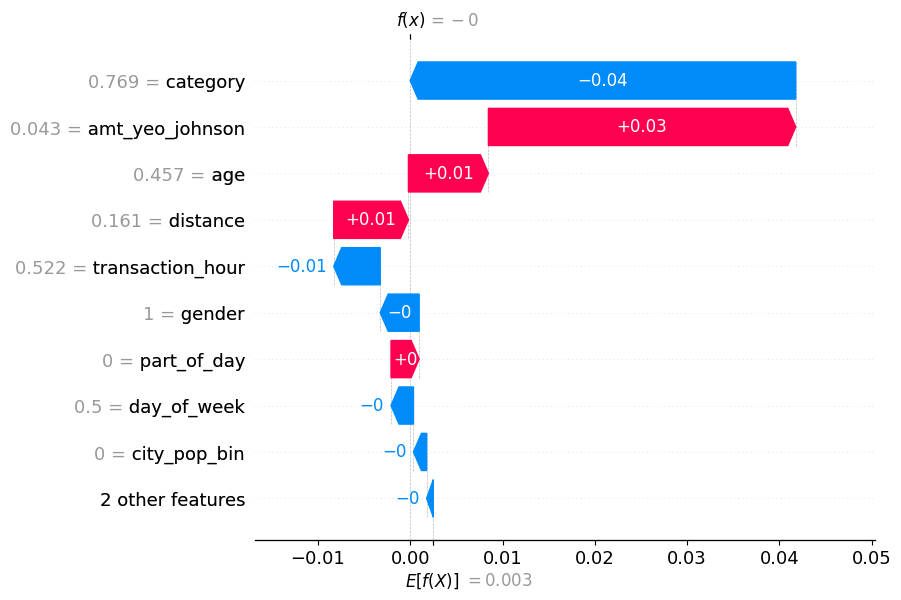

In [ ]:
shap.plots.waterfall(shap_values[0, :, positive_class_index])

In [ ]:
# Predictions for X_test
predictions = tuned_model.predict_proba(X_test)

# First observation's probability
print(f"Class probabilities: {predictions[0]}")

Class probabilities: [1. 0.]
